# Handling Missing Data

Let us assume that the following model generates the data
$$
\begin{align*}
    {x}_t &= {x}_{t-1} + c \\
    {y}_t &\sim \mathcal{N}\left({x}_{t}, p \right) 
\end{align*}
$$
with prior ${x}_0 \sim \mathcal{N}({m_{{x}_0}}, {v_{{x}_0}})$. Suppose that our measurement device fails to acquire data from time to time.  In this case, instead of scalar observation $\hat{y}_t \in \mathrm{R}$ we sometimes will catch `missing` observations.

In [1]:
using Rocket, ReactiveMP, GraphPPL, BenchmarkTools, Distributions

In [2]:
@model function smoothing(n, x0)
    
    P ~ Gamma(0.001, 0.001)
    x_prior ~ NormalMeanVariance(mean(x0), cov(x0)) 

    x = randomvar(n)
    y = datavar(Float64, n) where { allow_missing = true }
    c = constvar(1.0)

    x_prev = x_prior

    for i in 1:n
        x[i] ~ NormalMeanPrecision(x_prev, 1.0)
        y[i] ~ NormalMeanPrecision(x[i], P)
        
        x_prev = x[i]
    end

    return x, y
end

In [3]:
@rule NormalMeanPrecision(:μ, Marginalisation) (q_out::Any, q_τ::Missing) = missing
@rule NormalMeanPrecision(:μ, Marginalisation) (q_out::Missing, q_τ::Any) = missing

@rule NormalMeanPrecision(:τ, Marginalisation) (q_out::Any, q_μ::Missing) = missing
@rule NormalMeanPrecision(:τ, Marginalisation) (q_out::Missing, q_μ::Any) = missing

@rule typeof(+)(:in1, Marginalisation) (m_out::Missing, m_in2::Any) = missing
@rule typeof(+)(:in1, Marginalisation) (m_out::Any, m_in2::Missing) = missing

In [4]:
P = 1.0
n = 250

real_signal     = map(e -> sin(0.05 * e), collect(1:n))
noisy_data      = real_signal + rand(Normal(0.0, sqrt(P)), n);
missing_indices = 100:125 # clamp.(map(d -> rem(abs(d), n), rand(Int, Int(floor(n / 10)))), 1, n)
missing_data    = similar(noisy_data, Union{Float64, Missing}, )

copyto!(missing_data, noisy_data)

for index in missing_indices
    missing_data[index] = missing
end

In [5]:
constraints = @constraints begin
    q(x, P) = q(x)q(P)
end

Constraints:
	marginals form:
	messages form:
	factorisation:
		q(x, P) = q(x)q(P)


In [6]:
x0_prior = NormalMeanVariance(0.0, 1000.0)

result = inference(
    model = Model(smoothing, n, x0_prior), 
    data  = (y = missing_data,), 
    constraints = constraints,
    initmarginals = (P = Gamma(0.001, 0.001), ),
    returnvars = (x = KeepLast(),),
    iterations = 20
)

Inference results:
-----------------------------------------
x = Marginal[Marginal(NormalWeightedMeanPrecision{Float64}(xi=-0.09932938754413287, ...


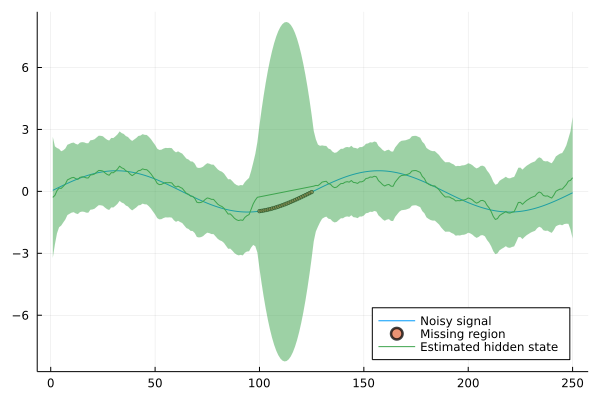

In [7]:
using Plots

plot(real_signal, label = "Noisy signal", legend = :bottomright)
scatter!(missing_indices, real_signal[missing_indices], ms = 2, opacity = 0.75, label = "Missing region")
plot!(mean.(result.posteriors[:x]), ribbon = var.(result.posteriors[:x]), label = "Estimated hidden state")